In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb


import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
from mizani.formatters import percent_format
%matplotlib inline
import sklearn, shap, xgboost


In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

## Data Generation Model

In [3]:
bn=gum.fastBN("coupon->loyalty->renewal;corporate customer->yearly consumption[5]->coupon;corporate customer->loyalty->recent visit")
bn.addArc("yearly consumption","loyalty")
bn.addArc("coupon","recent visit")
bn

(pyAgrum.BayesNet<double>@000002554874AB50) BN{nodes: 6, arcs: 8, domainSize: 160, dim: 74}

In [4]:
bn.cpt("corporate customer").fillWith([0.4,0.6])

(pyAgrum.Potential<double>@0000025548B78CE0) 
  corporate custome|
0        |1        |
---------|---------|
 0.4000  | 0.6000  |

In [5]:
bn.cpt("yearly consumption")[{"corporate customer":0}] = [0.3, 0.25, 0.2, 0.15, 0.1]
bn.cpt("yearly consumption")[{"corporate customer":1}] = [0.1, 0.15, 0.2, 0.25, 0.3]
bn.cpt("yearly consumption").normalizeAsCPT()

(pyAgrum.Potential<double>@0000025548B78D40) 
      ||  yearly consumption                             |
corpor||0        |1        |2        |3        |4        |
------||---------|---------|---------|---------|---------|
0     || 0.3000  | 0.2500  | 0.2000  | 0.1500  | 0.1000  |
1     || 0.1000  | 0.1500  | 0.2000  | 0.2500  | 0.3000  |

In [6]:
for i in range(5):
    monthly = (2*i+2) / 12
    bn.cpt("coupon")[{"yearly consumption":i}]=[1 - monthly,monthly]
bn.cpt("coupon").normalizeAsCPT()

(pyAgrum.Potential<double>@0000025548B78EE0) 
      ||  coupon           |
yearly||0        |1        |
------||---------|---------|
0     || 0.8333  | 0.1667  |
1     || 0.6667  | 0.3333  |
2     || 0.5000  | 0.5000  |
3     || 0.3333  | 0.6667  |
4     || 0.1667  | 0.8333  |

In [7]:
for i in range(5):
    bn.cpt("loyalty")[{"corporate customer":0,"coupon":0,"yearly consumption":i}]=[0.8-i*0.07,0.2+i*0.07]
    bn.cpt("loyalty")[{"corporate customer":0,"coupon":1,"yearly consumption":i}]=[0.7-i*0.15,0.3+i*0.15]
    bn.cpt("loyalty")[{"corporate customer":1,"coupon":0,"yearly consumption":i}]=[0.3,0.7]
    bn.cpt("loyalty")[{"corporate customer":1,"coupon":1,"yearly consumption":i}]=[0.3,0.7]
bn.cpt("loyalty").normalizeAsCPT()

(pyAgrum.Potential<double>@0000025548B78D00) 
                    ||  loyalty          |
coupon|corpor|yearly||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.8000  | 0.2000  |
1     |0     |0     || 0.7000  | 0.3000  |
0     |1     |0     || 0.3000  | 0.7000  |
1     |1     |0     || 0.3000  | 0.7000  |
0     |0     |1     || 0.7300  | 0.2700  |
1     |0     |1     || 0.5500  | 0.4500  |
[...8 more line(s) ...]
0     |1     |3     || 0.3000  | 0.7000  |
1     |1     |3     || 0.3000  | 0.7000  |
0     |0     |4     || 0.5200  | 0.4800  |
1     |0     |4     || 0.1000  | 0.9000  |
0     |1     |4     || 0.3000  | 0.7000  |
1     |1     |4     || 0.3000  | 0.7000  |

In [8]:
bn.cpt("recent visit")[{"loyalty":0,"coupon":0}]=[0.85,0.15] #was 0.15
bn.cpt("recent visit")[{"loyalty":0,"coupon":1}]=[0.6,0.4]   #was 0.35
bn.cpt("recent visit")[{"loyalty":1,"coupon":0}]=[0.35,0.65] #was 0.65
bn.cpt("recent visit")[{"loyalty":1,"coupon":1}]=[0.1,0.9]   #was 0.9
bn.cpt("recent visit")

(pyAgrum.Potential<double>@0000025548B79320) 
             ||  recent visit     |
loyalt|coupon||0        |1        |
------|------||---------|---------|
0     |0     || 0.8500  | 0.1500  |
1     |0     || 0.3500  | 0.6500  |
0     |1     || 0.6000  | 0.4000  |
1     |1     || 0.1000  | 0.9000  |

In [9]:
bn.cpt("renewal")[{"loyalty":0}]=[0.9,0.1]
bn.cpt("renewal")[{"loyalty":1}]=[0.1,0.9]
bn.cpt("renewal")

(pyAgrum.Potential<double>@0000025548B793C0) 
      ||  renewal          |
loyalt||0        |1        |
------||---------|---------|
0     || 0.9000  | 0.1000  |
1     || 0.1000  | 0.9000  |

In [10]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.posterior("renewal")

(pyAgrum.Potential<double>@0000025548B7AF00) 
  renewal          |
0        |1        |
---------|---------|
 0.4296  | 0.5704  |

In [11]:
ie.evidenceImpact("renewal", ["yearly consumption","corporate customer","coupon"])

(pyAgrum.Potential<double>@0000025548B7ABC0) 
                    ||  renewal          |
corpor|yearly|coupon||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.7400  | 0.2600  |
1     |0     |0     || 0.3400  | 0.6600  |
0     |1     |0     || 0.6840  | 0.3160  |
1     |1     |0     || 0.3400  | 0.6600  |
0     |2     |0     || 0.6280  | 0.3720  |
1     |2     |0     || 0.3400  | 0.6600  |
[...8 more line(s) ...]
0     |2     |1     || 0.4200  | 0.5800  |
1     |2     |1     || 0.3400  | 0.6600  |
0     |3     |1     || 0.3000  | 0.7000  |
1     |3     |1     || 0.3400  | 0.6600  |
0     |4     |1     || 0.1800  | 0.8200  |
1     |4     |1     || 0.3400  | 0.6600  |

In [12]:
ie.evidenceImpact("renewal", ["corporate customer","yearly consumption","coupon"]).extract({'coupon':1})

(pyAgrum.Potential<double>@0000025548B7AE40) 
             ||  renewal          |
corpor|yearly||0        |1        |
------|------||---------|---------|
0     |0     || 0.6600  | 0.3400  |
1     |0     || 0.3400  | 0.6600  |
0     |1     || 0.5400  | 0.4600  |
1     |1     || 0.3400  | 0.6600  |
0     |2     || 0.4200  | 0.5800  |
1     |2     || 0.3400  | 0.6600  |
0     |3     || 0.3000  | 0.7000  |
1     |3     || 0.3400  | 0.6600  |
0     |4     || 0.1800  | 0.8200  |
1     |4     || 0.3400  | 0.6600  |

## Sensitivity to Variable Selection

In [13]:
size=500000
foreground_size=5000
background_size=1000

#gum.generateCSV(bn,"data.csv",5000,random_order=True)
generator=gum.BNDatabaseGenerator(bn)
generator.setRandomVarOrder()
generator.drawSamples(size)
generator.toCSV('renewal_all.csv')
data=pd.read_csv('renewal_all.csv').sample(frac=1)
data.to_csv('renewal_all.csv', index=False)

### Selecting all known features

In [14]:
y=data["renewal"]
X=data.drop(["renewal","loyalty"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

params =  { "eta": 0.1, "subsample": 0.95, "max_depth": 4, "objective": "binary:logistic", "eval_metric":['logloss']}
model_1 = xgboost.train(
    params, dtrain, num_boost_round=10000,
    evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=100
)

fg = X_test.iloc[background_size:foreground_size+background_size]
bg = X_test.iloc[:background_size]

explainer = shap.Explainer(model_1, bg)
shap_values = explainer.shap_values(fg)

[0]	test-logloss:0.66949
[92]	test-logloss:0.55836


 96%|=================== | 4811/5000 [00:12<00:00]       

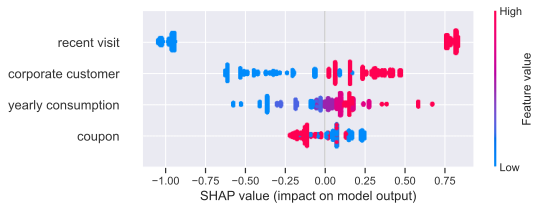

In [15]:
sns.set_theme()
shap.summary_plot(shap_values, features=fg)

### Excluding recent visit

In [16]:
X=data.drop(["renewal","loyalty","recent visit"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

model_2 = xgboost.train(
    params, dtrain, num_boost_round=2000,
    evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=500
)

fg = X_test.iloc[background_size:foreground_size+background_size]
bg = X_test.iloc[:background_size]

explainer = shap.Explainer(model_2, bg)
shap_values = explainer.shap_values(fg)

[0]	test-logloss:0.68172
[104]	test-logloss:0.63023


 98%|===================| 4913/5000 [00:13<00:00]        

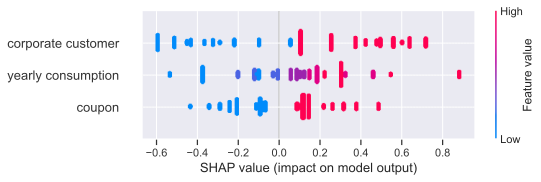

In [17]:
shap.summary_plot(shap_values, features=fg)

## Correct Calculation Of Average Causal Effect

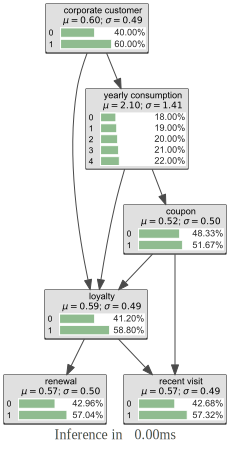

In [18]:
import pyAgrum.lib.notebook as gnb
gnb.showInference(bn)

In [22]:
cm=csl.CausalModel(bn)
cslnb.showCausalImpact(cm,"renewal", {"coupon"})

In [23]:
f, p, s = gum.causal.causalImpact(cm=cm, on="renewal", doing={"coupon"})
average_uplift = (p.extract({'coupon':1}) - p.extract({'coupon':0}))[1]
print(f'Average Uplift (ground truth) = {average_uplift:.2%}')

Average Uplift (ground truth) = 7.04%


### ICE Calculation
Feature selection should satisfy back-door criterion (e.g. model_2)

In [27]:
population = X_test.copy()
population['coupon'] = 1
population['yhat'] = model_2.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.6034759

In [28]:
population = X_test.copy()
population['coupon'] = 0
population['yhat'] = model_2.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.5312199

In [26]:
X=data.drop(["renewal","loyalty","recent visit"], axis=1).astype('float')

average_uplift = []
for i in range(20):
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)

    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)

    model = xgboost.train(
        params, dtrain, num_boost_round=200,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    population = X_test.copy()
    population['coupon'] = 1
    do_1 = np.mean(model.predict(xgboost.DMatrix(population)))
    population['coupon'] = 0
    do_0 = np.mean(model.predict(xgboost.DMatrix(population)))
    
    average_uplift.append(do_1 - do_0)

KeyboardInterrupt: 

In [ ]:
print(f'Average Uplift Estimate = {np.mean(average_uplift):.2%} +/- {np.std(average_uplift):.2%}')

It also works with a simpler selection.

In [26]:
X=data.drop(["renewal","loyalty","recent visit","corporate customer"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

model_3 = xgboost.train(
    params, dtrain, num_boost_round=200000,
    evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=100
)

[0]	test-logloss:0.68712
[74]	test-logloss:0.66080


In [27]:
population = X_test.copy()
population['coupon'] = 1
population['yhat'] = model_3.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.60412055

In [28]:
population = X_test.copy()
population['coupon'] = 0
population['yhat'] = model_3.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.5340907

### SHAP Calculation

Feature selection should satisfy back-door criterion (e.g. model_2)
True calculation should involve Shapley-Taylor diagonal, which does not exist in open-source ?

In [29]:
X=data.drop(["renewal","loyalty","recent visit"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

model_2 = xgboost.train(
    params, dtrain, num_boost_round=2000,
    evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=100
)

fg, bg, _, _ = sklearn.model_selection.train_test_split(X_test, y_test, stratify=y_test,
                                                        test_size=background_size,
                                                        train_size=foreground_size)

explainer = shap.Explainer(model_2, bg)
print(explainer.data.shape)
sigmoid(explainer.expected_value)

[0]	test-logloss:0.68172
[100]	test-logloss:0.62973
[125]	test-logloss:0.62973
(100, 3)


0.6055761164332937

In [30]:
shap_values = explainer.shap_values(fg)

 97%|=================== | 4834/5000 [00:16<00:00]       

In [31]:
sv = pd.DataFrame(shap_values, columns=X.columns, index=fg.index)

In [32]:
np.mean(data.renewal)

0.570382

In [33]:
np.mean(y_test)

0.570384

In [34]:
np.mean(model_2.predict(xgboost.DMatrix(bg)))

0.5778473

In [35]:
sigmoid(np.mean(model_2.predict(xgboost.DMatrix(bg), output_margin=True)))

0.5806363238112786

In [36]:
population = fg.copy()
population['shap'] = sigmoid(sv['coupon'] + explainer.expected_value)
population.groupby('coupon').agg(shap=('shap','mean')).reset_index()

,coupon,shap
0,0.0,0.566781
1,1.0,0.636824


In [37]:
population = fg.copy()
population['shap'] = sv['coupon'] 
results = population.groupby('coupon').agg(shap_min=('shap','min'),
                                           shap_max=('shap','max'),
                                           shap_avg=('shap','mean')).reset_index()
for v in ('shap_min', 'shap_max', 'shap_avg'):
    results[v] = sigmoid(results[v] + explainer.expected_value)
results

,coupon,shap_min,shap_max,shap_avg
0,0.0,0.497095,0.592664,0.566959
1,1.0,0.617441,0.693338,0.637194


### Shapley-Taylor Interaction Values

Unfortunately the group_shap library is SAP proprietary code and cannot be published. The diagonal of the Shapley-Taylor interaction values is "close" to the ICE. The main difference is that it is computed in the log-odds space.

In [21]:
import group_shap

gexpl = group_shap.XGBGroupExplainer(model_2, data=bg)
smv = gexpl.shap_main_values(fg)
sns.set_theme()

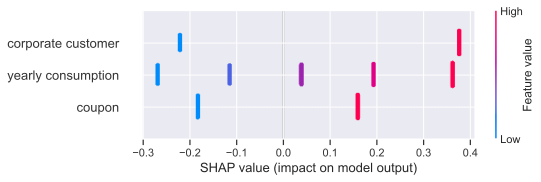

In [20]:
shap.summary_plot(smv.to_numpy(), features=fg)

Here we get for coupon an average contribution on the whole population, instead of a local contribution.

In [ ]:
population = fg.copy()
population['shap'] = smv['coupon']
results = population.groupby('coupon').agg(shap_min=('shap','min'),
                                 shap_max=('shap','max')).reset_index()
for v in ('shap_min', 'shap_max'):
    results[v] = sigmoid(results[v] + gexpl.baseline)
results

## Uplift 

### SHAP Values for coupons are non-zero for corporate customers
However coupons have no causal effect on corporate customers, by design of the data generator.

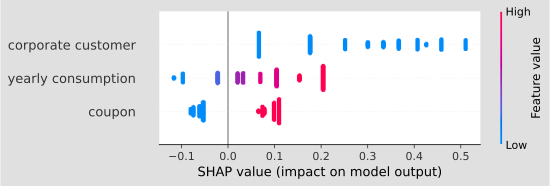

In [39]:
fg = X_test.iloc[background_size:background_size+foreground_size]
bg = X_test.iloc[:background_size]

fg_cc = fg[fg['corporate customer'] == 1]
explainer = shap.Explainer(model_2, bg)
shap_values = explainer.shap_values(fg_cc)
shap.summary_plot(shap_values, features=fg_cc)

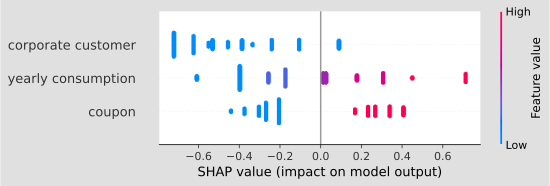

In [40]:
fg_ncc = fg[fg['corporate customer'] == 0]
explainer = shap.Explainer(model_2, bg)
shap_values = explainer.shap_values(fg_ncc)
shap.summary_plot(shap_values, features=fg_ncc)

### Correct Calculation

In [41]:
cslnb.showCausalImpact(cm,"renewal", {"coupon"}, knowing={"corporate customer", "yearly consumption"})

### Theorem: do(X) can be replaced with X if context satisfies backdoor-criterion

In [42]:
f, p, s = gum.causal.causalImpact(cm=cm, on="renewal", doing={"coupon"}, knowing={'yearly consumption','corporate customer'})
p

(pyAgrum.Potential<double>@000002D5B9F6B890) 
                    ||  renewal          |
coupon|corpor|yearly||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.7400  | 0.2600  |
1     |0     |0     || 0.6600  | 0.3400  |
0     |1     |0     || 0.3400  | 0.6600  |
1     |1     |0     || 0.3400  | 0.6600  |
0     |0     |1     || 0.6840  | 0.3160  |
1     |0     |1     || 0.5400  | 0.4600  |
[...8 more line(s) ...]
0     |1     |3     || 0.3400  | 0.6600  |
1     |1     |3     || 0.3400  | 0.6600  |
0     |0     |4     || 0.5160  | 0.4840  |
1     |0     |4     || 0.1800  | 0.8200  |
0     |1     |4     || 0.3400  | 0.6600  |
1     |1     |4     || 0.3400  | 0.6600  |

In [43]:
ie.evidenceImpact("renewal", ["yearly consumption","corporate customer", "coupon"]) - p 

(pyAgrum.Potential<double>@000002D5B9F6B350) 
                    ||  renewal          |
corpor|yearly|coupon||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.0000  | 0.0000  |
1     |0     |0     || 0.0000  | 0.0000  |
0     |1     |0     || 0.0000  | 0.0000  |
1     |1     |0     || 0.0000  | 0.0000  |
0     |2     |0     || -0.0000 | -0.0000 |
1     |2     |0     || 0.0000  | 0.0000  |
[...8 more line(s) ...]
0     |2     |1     || 0.0000  | 0.0000  |
1     |2     |1     || 0.0000  | 0.0000  |
0     |3     |1     || 0.0000  | 0.0000  |
1     |3     |1     || 0.0000  | 0.0000  |
0     |4     |1     || 0.0000  | 0.0000  |
1     |4     |1     || 0.0000  | 0.0000  |

### Wrap Up

In [44]:
uplift = (ie.evidenceImpact("renewal", ["corporate customer", "yearly consumption","coupon"]).extract({'coupon':1}) 
          - ie.evidenceImpact("renewal", ["corporate customer", "yearly consumption","coupon"]).extract({'coupon':0}))
uplift

(pyAgrum.Potential<double>@000002D5B9F6B6D0) 
             ||  renewal          |
corpor|yearly||0        |1        |
------|------||---------|---------|
0     |0     || -0.0800 | 0.0800  |
1     |0     || 0.0000  | 0.0000  |
0     |1     || -0.1440 | 0.1440  |
1     |1     || 0.0000  | 0.0000  |
0     |2     || -0.2080 | 0.2080  |
1     |2     || 0.0000  | 0.0000  |
0     |3     || -0.2720 | 0.2720  |
1     |3     || 0.0000  | 0.0000  |
0     |4     || -0.3360 | 0.3360  |
1     |4     || 0.0000  | 0.0000  |

### Using a Predictive Model

In [45]:
apply_df = X_test.copy()
apply_df['uplift'] = model_2.predict(xgboost.DMatrix(apply_df.assign(coupon=1))) - model_2.predict(xgboost.DMatrix(apply_df.assign(coupon=0)))
result = apply_df.groupby(['yearly consumption','corporate customer']).agg(frequency=('uplift','count'),
                                                                           predicted = ('uplift', 'mean')).reset_index()
expected = []
for i in range(len(result)):
    row = result.iloc[i]
    expected.append(uplift.extract({'yearly consumption':int(row['yearly consumption']),
                                    'corporate customer':int(row['corporate customer'])}).toarray()[1])
result['ground truth'] = expected
result['profile'] = np.where(result['corporate customer'], 'Corporate Customer', 'Individual Customer')
result

,yearly consumption,corporate customer,frequency,predicted,ground truth,profile
0,0.0,0.0,14997,0.069271,0.080,Individual Customer
1,0.0,1.0,7464,0.003406,0.000,Corporate Customer
2,1.0,0.0,12457,0.155214,0.144,Individual Customer
3,1.0,1.0,11193,0.003362,0.000,Corporate Customer
4,2.0,0.0,10170,0.208679,0.208,Individual Customer
5,2.0,1.0,14730,-0.009218,0.000,Corporate Customer
6,3.0,0.0,7415,0.286139,0.272,Individual Customer
7,3.0,1.0,19017,0.004110,0.000,Corporate Customer
8,4.0,0.0,4949,0.326510,0.336,Individual Customer
9,4.0,1.0,22608,0.001389,0.000,Corporate Customer


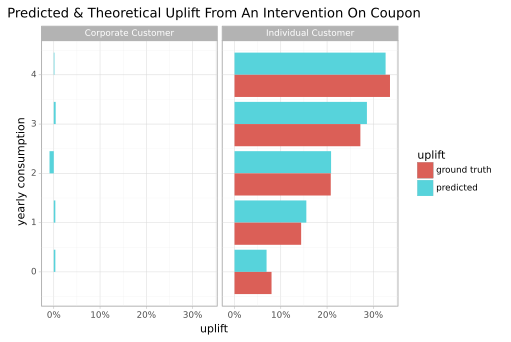

<ggplot: (194811893670)>

In [46]:
(ggplot(result.melt(id_vars=('yearly consumption', 'profile'), value_vars=['predicted','ground truth'], var_name='uplift')
, aes(x='yearly consumption', y='value', fill='uplift'))
 + geom_bar(stat='identity', position='dodge')
 + scale_y_continuous(name='uplift', labels=percent_format(), breaks=np.arange(0,2,0.1))
 + facet_wrap('~profile')
 + theme_light()
 + coord_flip()
 + ggtitle("Predicted & Theoretical Uplift From An Intervention On Coupon")
)

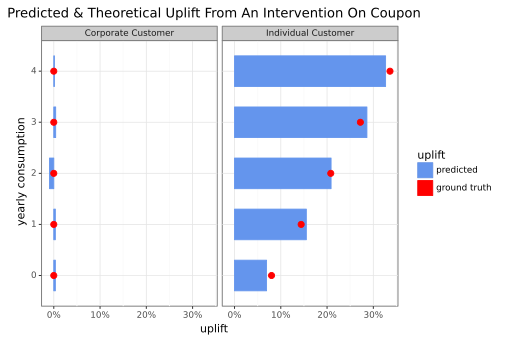

<ggplot: (194811973611)>

In [47]:
reshaped = result.melt(id_vars=('yearly consumption', 'profile'), 
                    value_vars=['predicted','ground truth'], 
                    var_name='uplift')
reshaped['yearly consumption'] = pd.Categorical(reshaped['yearly consumption'].astype('int'))
(ggplot(mapping=aes(x='yearly consumption', y='value', color='uplift', fill='uplift'))
 + geom_bar(reshaped[reshaped['uplift']=='predicted'],
            stat='identity', width=0.6)
 + geom_point(reshaped[reshaped['uplift']=='ground truth'], 
              size=3)
 + scale_y_continuous(name='uplift', labels=percent_format(), breaks=np.arange(0,2,0.1))
 + facet_wrap('~profile')
 + theme_bw()
 + scale_color_manual(values=('cornflowerblue','red'))
 + scale_fill_manual(values=('cornflowerblue','red'))
 + coord_flip()
 + ggtitle("Predicted & Theoretical Uplift From An Intervention On Coupon")
)

In [49]:
X=data.drop(["renewal","loyalty","recent visit"], axis=1).astype('float')

result = []

for i in range(5):
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, random_state=i)
    
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)

    model = xgboost.train(
        params, dtrain, num_boost_round=2000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=None
    )

    apply_df = X_test.copy()
    apply_df['uplift'] = model.predict(xgboost.DMatrix(apply_df.assign(coupon=1))) - model.predict(xgboost.DMatrix(apply_df.assign(coupon=0)))
    result.append(apply_df.groupby(['yearly consumption',
                                    'corporate customer']).agg(frequency=('uplift','count'),
                                                               predicted = ('uplift', 'mean')).reset_index())
result = pd.concat(result)

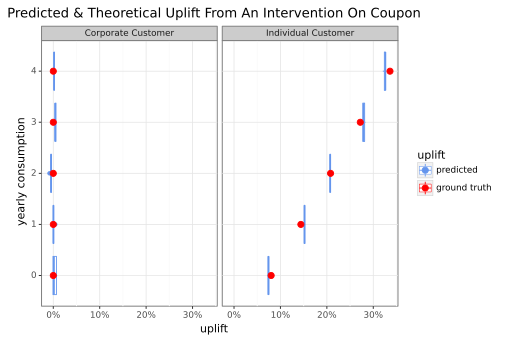

<ggplot: (194819492471)>

In [51]:
result['profile'] = np.where(result['corporate customer'], 'Corporate Customer', 'Individual Customer')
reshaped_2 = result.melt(id_vars=('yearly consumption', 'profile'), 
                    value_vars=['predicted'], 
                    var_name='uplift')
reshaped_2['yearly consumption'] = pd.Categorical(reshaped_2['yearly consumption'].astype('int'))

(ggplot(data=reshaped_2, mapping=aes(x='yearly consumption', y='value', color='uplift'))
 + geom_boxplot()
 + geom_point(reshaped[reshaped['uplift']=='ground truth'], 
              size=3)
 + scale_y_continuous(name='uplift', labels=percent_format(), breaks=np.arange(0,2,0.1))
 + facet_wrap('~profile')
 + theme_bw()
 + scale_color_manual(values=('cornflowerblue','red'))
 + coord_flip()
 + ggtitle("Predicted & Theoretical Uplift From An Intervention On Coupon")
)